In [1]:
# mit Anpassungen für das Seminar
#
# nach Aurelius Geron (2023) https://github.com/ageron/handson-ml3


# wegen CPU Einsatz epochs=50

**Chapter 15 – Processing Sequences Using RNNs

In this chapter we explored the fundamentals of RNNs and used them to process sequences (namely, time series). In the process we also looked at other ways to process sequences, including CNNs.

# Setup

In [2]:
import sys
import numpy as np
import tensorflow as tf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [3]:


epochs=50   # für GPU 500


In [4]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig("/", format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


# Basic RNNs

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [6]:
# https://github.com/ageron/data/raw/main/ridership.tgz herunterladen
# die Dateien auf Google Drive > Meine Colab Notebooks kopieren durch drag und drop vom Explorer.
# oder in das lokalen python Verzeichnis ablegen


In [11]:
# from google.colab import drive
# drive.mount('/content/drive')

import pandas as pd
from pathlib import Path

# path = Path("/content/drive/MyDrive/Colab Notebooks/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
path = Path("CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [ ]:
df.head()

Let's look at the first few months of 2019 (note that Pandas treats the range boundaries as inclusive):

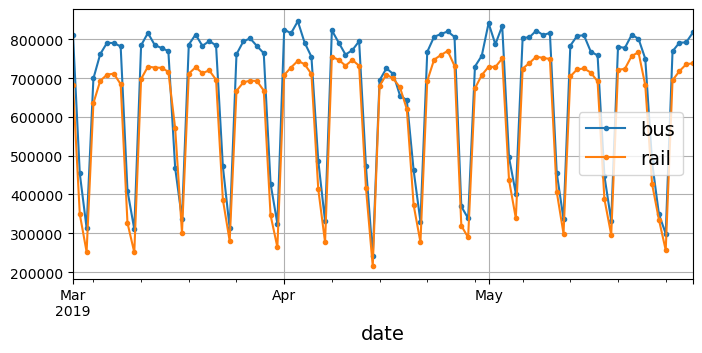

In [12]:
# zeige bivariate Zeitreihe

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
#save_fig("daily_ridership_plot")  # extra code – saves the figure for the book
plt.show()

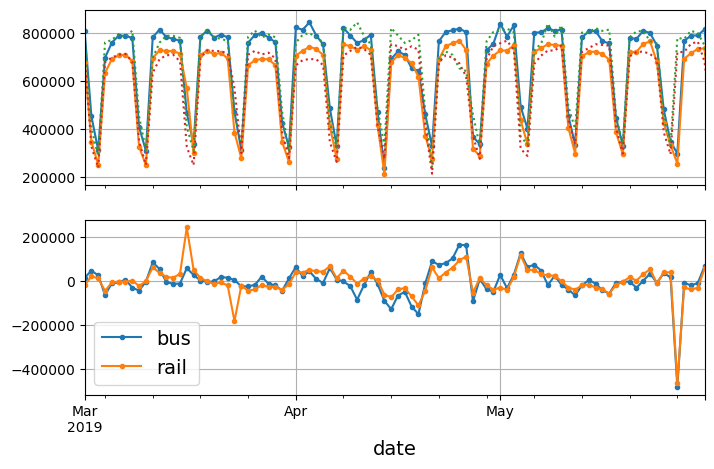

In [13]:
# zeige zusätzlich einen dümmst anzunehmende Schätzer, nämlich einfach den Wert von von 7 Tagen nehmen.
# oben mit den um 7 Tagen verschobenen Zeitreihen
# im unteren Plot in als Differenzen zwischen Vorhage und ground truth
# siehe schon gut aus, MAE bei 40 000


diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])  # extra code – beautifies the plot
#save_fig("differencing_plot")  # extra code – saves the figure for the book
plt.show()

In [14]:
# W work day, A Sateruday, U Sunday
display(list(df.loc["2019-05-17":"2019-05-27"]["day_type"]))


display(df.loc["2019-05-17":"2019-05-27"])
display(diff_7.loc["2019-05-17":"2019-05-27"])
display(pd.concat([diff_7.loc["2019-05-17":"2019-05-27"], df.loc["2019-05-17":"2019-05-27"]], axis=1))

['W', 'A', 'U', 'W', 'W', 'W', 'W', 'W', 'A', 'U', 'U']

,day_type,bus,rail
date,,,
2019-05-17,W,758399,691390
2019-05-18,A,448115,388373
2019-05-19,U,332006,295929
2019-05-20,W,781061,721397
2019-05-21,W,777647,723782
2019-05-22,W,811376,756639
2019-05-23,W,801697,766717
2019-05-24,W,749827,681443
2019-05-25,A,483109,426932


,bus,rail
date,,
2019-05-17,-57869.0,-57916.0
2019-05-18,-8247.0,-19069.0
2019-05-19,-4470.0,-3070.0
2019-05-20,-2596.0,17071.0
2019-05-21,-31216.0,1359.0
2019-05-22,1086.0,31878.0
2019-05-23,33447.0,52435.0
2019-05-24,-8572.0,-9947.0
2019-05-25,34994.0,38559.0


,bus,rail,day_type,bus,rail
date,,,,,
2019-05-17,-57869.0,-57916.0,W,758399,691390
2019-05-18,-8247.0,-19069.0,A,448115,388373
2019-05-19,-4470.0,-3070.0,U,332006,295929
2019-05-20,-2596.0,17071.0,W,781061,721397
2019-05-21,-31216.0,1359.0,W,777647,723782
2019-05-22,1086.0,31878.0,W,811376,756639
2019-05-23,33447.0,52435.0,W,801697,766717
2019-05-24,-8572.0,-9947.0,W,749827,681443
2019-05-25,34994.0,38559.0,A,483109,426932


Mean absolute error (MAE), also called mean absolute deviation (MAD):

In [15]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

In [13]:
#Mean absolute percentage error (MAPE):
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

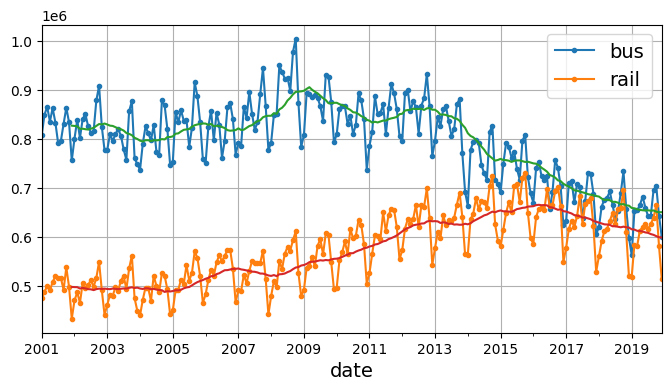

In [14]:
# Now let's look at the yearly seasonality and the long-term trends:
# 200 Tage als Bezug sorgt für Detrending

# je gibt also eine jährliche Saisonalität, auch wenn errauschter als die wöchentliche.
# Einfache Differenzbildung glättet jährlichen Zyklus und den linearen Trend weg.


period = slice("2001", "2019")
#df_monthly = df.resample('M').mean()  # compute the mean for each month
#rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

# Drop the 'day_type' column before resampling to calculate the mean
df_monthly = df[['bus', 'rail']].resample('M').mean()  # compute the mean for each month for numerical columns only
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

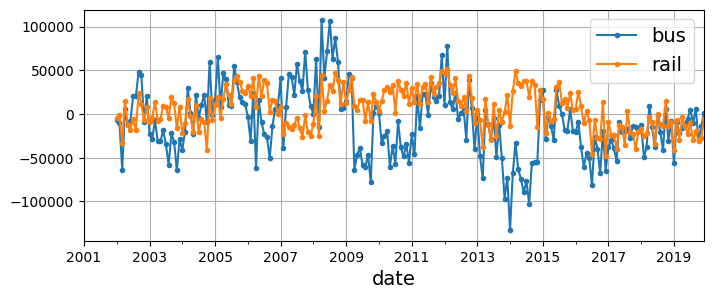

In [15]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
plt.show()

In [17]:
# ARIMA aus dem package statsmodel

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series,
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In [18]:
y_pred[0]  # ARIMA forecast

C:\Users\noname\AppData\Local\Temp\ipykernel_42152\3394422362.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred[0]  # ARIMA forecast


427758.62622240453

In [19]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [20]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

In [21]:
# Vorhersage für die Testdaten in time_period und MAE berechnen
# MAE 32000 ist immer noch gross.

origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],  # train on data up to "today"
                  order=(1, 0, 0),  # order=(1, 0, 0) bedeutet, dass p = 1, d = 0, q = 0,
                  seasonal_order=(0, 1, 1, 7))  # seasonal_order=(0, 1, 1, 7) steht für P = 0, D = 1, Q= 1 und s = 7. 
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

In [22]:
mae

32040.720090488467

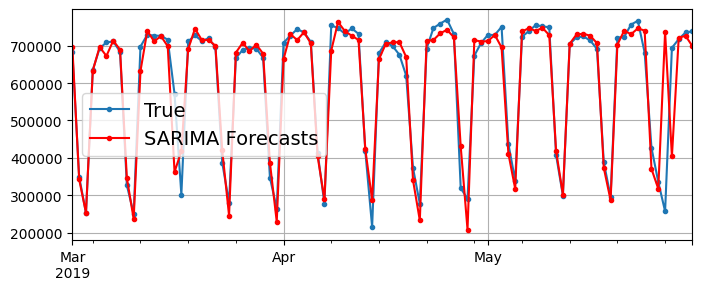

In [23]:
#  displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

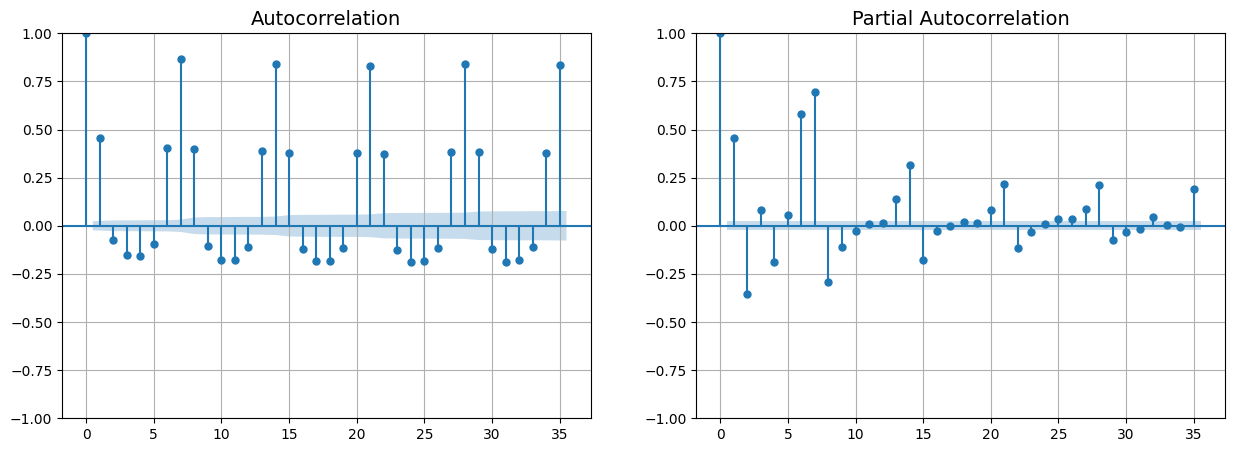

In [24]:
#  shows how to plot the Autocorrelation Function (ACF) and the
#              Partial Autocorrelation Function (PACF) ohne Einfluss der Zwischenlagwerte.
# Diese Diagramme helfen, die geeigneten Werte für p und q in ARIMA zu bestimmen.
# Korelation für lag=0 ist immer 1, da dies die Selbstkorrelation ist.

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

In [ ]:
# und Datenaufbereitung für RNN
# Für die Vorhersage sollen zu jedem Tag 56 Vorgänger bereit stehen.



In [28]:
# Hilfsfunktion der Datenaufbereitung

def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [29]:
# Dividiert duch 1e6 um die Originalzahl zwischen 0 und 1 zu bringen.

rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [30]:
seq_length = 56
tf.random.set_seed(42)  # extra code – ensures reproducibility
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [31]:
# Einfache lineare Regression durch die Hintertür.
# Ergebnis mit 37000 ist besser als das 7 Tage Shift Mododell, schlechter als SARIMA.

# auf Colab early stopping nach 169 Epochen!
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=100, #org:500
                    callbacks=[early_stopping_cb])

Epoch 1/100


C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0459 - mae: 0.2385 - val_loss: 0.0068 - val_mae: 0.0884
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - mae: 0.0893 - val_loss: 0.0058 - val_mae: 0.0779
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0073 - mae: 0.0878 - val_loss: 0.0054 - val_mae: 0.0757
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0066 - mae: 0.0864 - val_loss: 0.0059 - val_mae: 0.0801
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0058 - mae: 0.0808 - val_loss: 0.0050 - val_mae: 0.0725
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0056 - mae: 0.0771 - val_loss: 0.0056 - val_mae: 0.0800
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - mae: 0.0822 - val_loss: 0.0046 - val_mae: 0.0691
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0048 - mae: 0.0716 - val_loss: 0.0045 - val_mae: 0.0684
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - mae: 0.

In [32]:
# extra code – evaluates the model
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0019 - mae: 0.0406


39005.860686302185

In [33]:
## Using a Simple RNN
tf.random.set_seed(42)  # extra code – ensures reproducibility
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])
'''
Validierungs-MAE ist größer als 100.000! Autsch. Aber das war zu erwarten, weil
Nur 1 rekurrentes neuron mit zwei Eingabewerten -> kann bei jedem Zeitschritt nur den Eingabewert des aktuellen und den Ausgabewert des vorherigen Zeitschritts verwenden
und daher zwei Gewichte und einen Bias-Term
tanh als default Aktivierungsfunktion kennt nur  Werte zwischen –1 und +1, dies entspricht aber nicht dem Input. Tanh kann also einige Werte gar nicht vorhersagen.
'''

C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
# extra code – defines a utility function we'll reuse several time

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=epochs):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [35]:
# Achtung Rechenzeit wegen Anzahl Epochen
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0799 - mae: 0.3546 - val_loss: 0.0133 - val_mae: 0.1167
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0129 - mae: 0.1233 - val_loss: 0.0122 - val_mae: 0.1178
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0118 - mae: 0.1288 - val_loss: 0.0119 - val_mae: 0.1199
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0115 - mae: 0.1289 - val_loss: 0.0118 - val_mae: 0.1196
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - mae: 0.1271 - val_loss: 0.0118 - val_mae: 0.1190
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - mae: 0.1298 - val_loss: 0.0118 - val_mae: 0.1187
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0119 - mae: 0.1305 - val_loss: 0.0117 - val_mae: 0.1183
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - mae: 0.1284 - val_loss: 0.0116 - val_mae: 0.1193
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - mae:

107391.87151193619

In [36]:
# Neues RNN mit 32 Zellen
# MAE liegt bei 27000, wird also besser. 


tf.random.set_seed(42)  # extra code – ensures reproducibility
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [37]:
# Achtung Rechenzeit wegen Anzahl Epochen

fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0271 - mae: 0.1796 - val_loss: 0.0032 - val_mae: 0.0595
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0054 - mae: 0.0729 - val_loss: 0.0025 - val_mae: 0.0514
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - mae: 0.0649 - val_loss: 0.0025 - val_mae: 0.0510
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0038 - mae: 0.0583 - val_loss: 0.0022 - val_mae: 0.0445
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0037 - mae: 0.0554 - val_loss: 0.0023 - val_mae: 0.0451
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0034 - mae: 0.0517 - val_loss: 0.0022 - val_mae: 0.0410
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - mae: 0.0656 - val_loss: 0.0023 - val_mae: 0.0399
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0036 - mae: 0.0549 - val_loss: 0.0020 - val_mae: 0.0361
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - ma

28415.022417902946

In [38]:
# Neues Deep RNN mit 2x 32 Zellen
# MAE liegt bei 30000. Eventuell aber schon zu gross. siehe Sprünge der Verlustfunktionen. UNd MAE ist besser mit einer Schicht.


# To build a deep sequence-to-sequence RNN using Keras, you must set `return_sequences=True` for all RNN layers. 
# To build a sequence-to-vector RNN, you must set `return_sequences=True` for all RNN layers except for the top RNN layer, 
#     which must have `return_sequences=False` (or do not set this argument at all, since `False` is the default).


tf.random.set_seed(42)  # extra code – ensures reproducibility
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [39]:
# Achtung Rechenzeit wegen Anzahl Epochen bis early stopping
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0869 - mae: 0.3015 - val_loss: 0.0078 - val_mae: 0.1072
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0082 - mae: 0.0982 - val_loss: 0.0028 - val_mae: 0.0551
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0054 - mae: 0.0732 - val_loss: 0.0023 - val_mae: 0.0450
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0040 - mae: 0.0590 - val_loss: 0.0030 - val_mae: 0.0547
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0048 - mae: 0.0652 - val_loss: 0.0021 - val_mae: 0.0426
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0053 - mae: 0.0722 - val_loss: 0.0019 - val_mae: 0.0358
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0039 - mae: 0.0541 - val_loss: 0.0025 - val_mae: 0.0452
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0037 - mae: 0.0511 - val_loss: 0.0019 - val_mae: 0.0354
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.003

30842.83322095871

## Multivariate time series

In [40]:
#  Multivariate time series.
# RNN sind flexibel. AIMA Modele nicht.

df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type

In [41]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [42]:
tf.random.set_seed(42)  # extra code – ensures reproducibility

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train[['bus', 'rail', 'next_day_type_U', 'next_day_type_W', 'next_day_type_A']].astype(np.float32).values,  # Explicitly cast to float32
    targets=mulvar_train["rail"][seq_length:].astype(np.float32).values,  # Explicitly cast to float32
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid[['bus', 'rail', 'next_day_type_U', 'next_day_type_W', 'next_day_type_A']].astype(np.float32).values,  # Explicitly cast to float32
    targets=mulvar_valid["rail"][seq_length:].astype(np.float32).values,  # Explicitly cast to float32
    sequence_length=seq_length,
    batch_size=32
)

In [43]:
# 32-RNN bauen für 5 Variablen.
# MAE bei 24000, also bisher bestens.


tf.random.set_seed(42)  # extra code – ensures reproducibility
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
# extra code – compiles, fits, and evaluates the model, like earlier
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0349 - mae: 0.2015 - val_loss: 0.0025 - val_mae: 0.0558
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0030 - mae: 0.0560 - val_loss: 0.0029 - val_mae: 0.0665
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0026 - mae: 0.0540 - val_loss: 0.0019 - val_mae: 0.0527
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - mae: 0.0414 - val_loss: 0.0019 - val_mae: 0.0525
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0015 - mae: 0.0393 - val_loss: 7.3080e-04 - val_mae: 0.0267
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - mae: 0.0372 - val_loss: 6.3628e-04 - val_mae: 0.0247
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - mae: 0.0355 - val_loss: 9.5546e-04 - val_mae: 0.0329
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0016 - mae: 0.0430 - val_loss: 7.7350e-04 - val_mae: 0.0287
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - 

24289.896711707115

In [45]:
# Modell zur Vorhersage beider Variablen bauen
# Auf 2 Aufgaben trainiert ist eine Art Regularisierung
#  build and train a multitask RNN that forecasts both bus and rail
# im output also 2 Variablen
# MAE bei 25 000

tf.random.set_seed(42)

seq_length = 56

train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train[['bus', 'rail', 'next_day_type_U', 'next_day_type_W', 'next_day_type_A']].astype(np.float32).values,  # Explicitly cast to float32
    targets=mulvar_train[["bus", "rail"]][seq_length:].astype(np.float32).values,  # Explicitly cast to float32 and select correct columns
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid[['bus', 'rail', 'next_day_type_U', 'next_day_type_W', 'next_day_type_A']].astype(np.float32).values,  # Explicitly cast to float32
    targets=mulvar_valid[["bus", "rail"]][seq_length:].astype(np.float32).values,  # Explicitly cast to float32 and select correct columns
    sequence_length=seq_length,
    batch_size=32
)

tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/50


C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0943 - mae: 0.3363 - val_loss: 0.0091 - val_mae: 0.1136
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0055 - mae: 0.0792 - val_loss: 0.0018 - val_mae: 0.0478
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0029 - mae: 0.0517 - val_loss: 0.0021 - val_mae: 0.0537
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mae: 0.0495 - val_loss: 0.0011 - val_mae: 0.0356
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0025 - mae: 0.0481 - val_loss: 0.0014 - val_mae: 0.0413
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - mae: 0.0464 - val_loss: 8.8172e-04 - val_mae: 0.0308
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0021 - mae: 0.0454 - val_loss: 0.0011 - val_mae: 0.0340
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - mae: 0.0441 - val_loss: 0.0011 - val_mae: 0.0365
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0016 - mae: 0.04

25475.37349164486

In [46]:
# evaluates the naive forecasts for bus
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [47]:

# evaluates the multitask RNN's forecasts both bus and rail
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = tf.keras.metrics.MeanAbsoluteError()
    mae.update_state(mulvar_valid[name][seq_length:], Y_preds_valid[:, idx]) #Update the metric state with the predictions and targets
    mae_result = mae.result().numpy() * 1e6 # Get the result as a NumPy array and multiply to scale
    print(name, int(mae_result))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
bus 25659
rail 25291


## Forecasting Several Steps Ahead

In [48]:
# VOrhersagen für 14 Tage sammeln
# eigentlich keine gute Idee für so lange, denn Fehler in den Vorhersagen summieren sich.

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


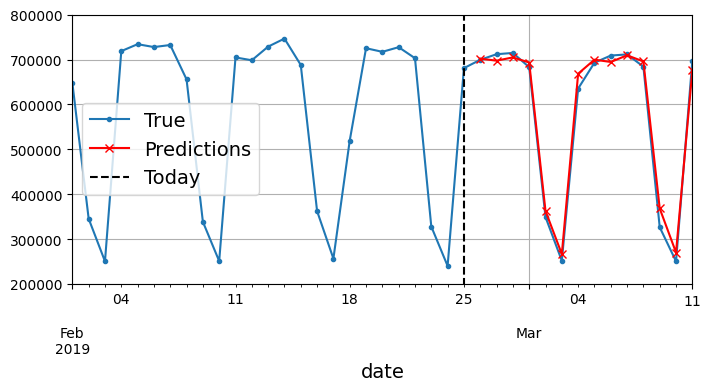

In [49]:
# plot i

# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total.
Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
#save_fig("forecast_ahead_plot")
plt.show()

In [50]:
# RNN anwenden
# zuerst Datenaufbereitung
# MAE 54 000
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    # Convert the series to a NumPy array and cast to float32
    series_np = series.astype(np.float32).to_numpy()

    ds = to_windows(tf.data.Dataset.from_tensor_slices(series_np), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, target_col]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)    

In [51]:
# 32-RNN definieren
tf.random.set_seed(42)  
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [52]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/50
     27/Unknown 2s 8ms/step - loss: 0.1507 - mae: 0.4185

C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1338 - mae: 0.3875 - val_loss: 0.0151 - val_mae: 0.1288
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0117 - mae: 0.1187 - val_loss: 0.0090 - val_mae: 0.0971
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0079 - mae: 0.0926 - val_loss: 0.0075 - val_mae: 0.0867
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0069 - mae: 0.0864 - val_loss: 0.0074 - val_mae: 0.0867
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0063 - mae: 0.0813 - val_loss: 0.0070 - val_mae: 0.0844
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0058 - mae: 0.0772 - val_loss: 0.0060 - val_mae: 0.0765
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0056 - mae: 0.0756 - val_loss: 0.0064 - val_mae: 0.0807
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0053 - mae: 0.0724 - val_loss: 0.0059 - val_mae: 0.0761
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0050 - mae: 0.0703 - v

51014.13279771805

In [53]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
MAE for +1: 27,766
MAE for +2: 32,283
MAE for +3: 29,526
MAE for +4: 30,179
MAE for +5: 32,629
MAE for +6: 41,385
MAE for +7: 31,973
MAE for +8: 37,481
MAE for +9: 30,792
MAE for +10: 41,231
MAE for +11: 35,251
MAE for +12: 37,549
MAE for +13: 37,628
MAE for +14: 37,831


# Deep RNNs with Layer Norm

In [54]:
# Im Kampf gegen instabile Gradienten kann man Layer Normalisierung in selbst definierte Zelle einbauen.

# alternativ Hyperparameter dropout und recurrent_dropout

# MAE 100 000

class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [55]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\layers\layer.py:396: UserWarning: `build()` was called on layer 'ln_simple_rnn_cell', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Just training for 5 epochs to show that it works (you can increase this if you want):

In [56]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.1690 - mae: 0.4325 - val_loss: 0.0204 - val_mae: 0.1526
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0139 - mae: 0.1362 - val_loss: 0.0142 - val_mae: 0.1214
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0106 - mae: 0.1155 - val_loss: 0.0116 - val_mae: 0.1099
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0094 - mae: 0.1063 - val_loss: 0.0108 - val_mae: 0.1053
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0085 - mae: 0.0981 - val_loss: 0.0101 - val_mae: 0.1013
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0112 - mae: 0.1060


101278.53602170944

In [57]:
# Creating a Custom RNN Class
# he RNN class is not magical. In fact, it's not too hard to implement your own RNN class.

# MAE 100 000

class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences

    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # fallback to zeros if self.cell has no get_initial_state() method
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                             dtype=inputs.dtype)]

    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)

        if self.return_sequences:
            # stack the outputs into an array of shape
            # [time steps, batch size, dims], then transpose it to shape
            # [batch size, time steps, dims]
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

Note that `@tf.function` requires the `outputs` variable to be created before the `for` loop, which is why we initialize its value to a zero tensor, even though we don't use that value at all. Once the function is converted to a graph, this unused value will be pruned from the graph, so it doesn't impact performance. Similarly, `@tf.function` requires the `sequences` variable to be created before the `if` statement where it is used, even if `self.return_sequences` is `False`, so we create a `TensorArray` of size 0 in this case.

In [58]:
tf.random.set_seed(42)

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

C:\Users\noname\AppData\Local\Temp\ipykernel_42152\3927794187.py:3: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Just training for 5 epochs to show that it works (you can increase this if you want):

In [59]:
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5


C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\optimizers\base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['sequential_8/my_rnn/ln_simple_rnn_cell_1/simple_rnn_cell_1/kernel', 'sequential_8/my_rnn/ln_simple_rnn_cell_1/simple_rnn_cell_1/recurrent_kernel', 'sequential_8/my_rnn/ln_simple_rnn_cell_1/simple_rnn_cell_1/bias', 'sequential_8/my_rnn/ln_simple_rnn_cell_1/layer_normalization_1/gamma', 'sequential_8/my_rnn/ln_simple_rnn_cell_1/layer_normalization_1/beta'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2159 - mae: 0.5155 - val_loss: 0.0476 - val_mae: 0.2348
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0340 - mae: 0.1938 - val_loss: 0.0229 - val_mae: 0.1523
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0188 - mae: 0.1383 - val_loss: 0.0174 - val_mae: 0.1304
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0147 - mae: 0.1205 - val_loss: 0.0146 - val_mae: 0.1193
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0125 - mae: 0.1105 - val_loss: 0.0130 - val_mae: 0.1126
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0144 - mae: 0.1184


112640.58202505112

# LSTMs

In [60]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [61]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0974 - mae: 0.3560 - val_loss: 0.0195 - val_mae: 0.1599
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0179 - mae: 0.1631 - val_loss: 0.0177 - val_mae: 0.1435
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0156 - mae: 0.1510 - val_loss: 0.0166 - val_mae: 0.1397
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0147 - mae: 0.1456 - val_loss: 0.0157 - val_mae: 0.1363
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0140 - mae: 0.1417 - val_loss: 0.0151 - val_mae: 0.1323
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0158 - mae: 0.1349


132309.33248996735

# GRUs

In [62]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [63]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1304 - mae: 0.4110 - val_loss: 0.0188 - val_mae: 0.1536
Epoch 2/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0154 - mae: 0.1442 - val_loss: 0.0143 - val_mae: 0.1315
Epoch 3/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0123 - mae: 0.1292 - val_loss: 0.0134 - val_mae: 0.1247
Epoch 4/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0114 - mae: 0.1229 - val_loss: 0.0126 - val_mae: 0.1213
Epoch 5/5
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0107 - mae: 0.1184 - val_loss: 0.0119 - val_mae: 0.1183
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0128 - mae: 0.1215


118299.06702041626

## Using One-Dimensional Convolutional Layers to Process Sequences

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [64]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                       shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Just training for 5 epochs to show that it works (you can increase this if you want):

In [77]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=50)

Epoch 1/50
     29/Unknown 3s 18ms/step - loss: 0.0092 - mae: 0.1064

C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.0092 - mae: 0.1064 - val_loss: 0.0102 - val_mae: 0.1066
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0085 - mae: 0.1013 - val_loss: 0.0094 - val_mae: 0.1027
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0079 - mae: 0.0967 - val_loss: 0.0088 - val_mae: 0.0993
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0073 - mae: 0.0925 - val_loss: 0.0084 - val_mae: 0.0964
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0069 - mae: 0.0895 - val_loss: 0.0080 - val_mae: 0.0936
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0066 - mae: 0.0869 - val_loss: 0.0077 - val_mae: 0.0911
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0064 - mae: 0.0850 - val_loss: 0.0076 - val_mae: 0.0899
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0062 - mae: 0.0828 - val_loss: 0.0073 - val_mae: 0.0879
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0060 - mae: 0.

53099.76637363434

## WaveNet

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

In [66]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Just training for 5 epochs to show that it works (you can increase this if you want):

In [78]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=50)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0126 - mae: 0.1351 - val_loss: 0.0132 - val_mae: 0.1225
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0109 - mae: 0.1205 - val_loss: 0.0115 - val_mae: 0.1153
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0095 - mae: 0.1099 - val_loss: 0.0104 - val_mae: 0.1093
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0085 - mae: 0.1030 - val_loss: 0.0094 - val_mae: 0.1038
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0076 - mae: 0.0968 - val_loss: 0.0087 - val_mae: 0.0989
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0071 - mae: 0.0924 - val_loss: 0.0082 - val_mae: 0.0943
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0066 - mae: 0.0879 - val_loss: 0.0077 - val_mae: 0.0897
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0062 - mae: 0.0836 - val_loss: 0.0073 - val_mae: 0.0854
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.005

55618.37926506996

# Extra Material – Wavenet Implementation

Here is the original WaveNet defined in the paper: it uses Gated Activation Units instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [68]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)

    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [69]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                            dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [70]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

Just training for 5 epochs to show that it works (you can increase this if you want):

In [71]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5


C:\myPrograms\Anaconda3\envs\TF\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_86']
Received: inputs=Tensor(shape=(None, None, 5))
  warnings.warn(msg)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.1186 - mae: 0.4083 - val_loss: 0.0212 - val_mae: 0.1501
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0137 - mae: 0.1347 - val_loss: 0.0131 - val_mae: 0.1168
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0099 - mae: 0.1126 - val_loss: 0.0107 - val_mae: 0.1043
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0079 - mae: 0.0972 - val_loss: 0.0093 - val_mae: 0.0969
Epoch 5/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0068 - mae: 0.0874 - val_loss: 0.0081 - val_mae: 0.0898
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0081 - mae: 0.0898


89798.42066764832